In [4]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Performing an event study by modeling a trend

In [75]:
num = 2000
np.random.seed(0)
Treated = np.hstack((np.zeros(num // 2), np.ones(num // 2)))
Time = np.arange(num)
Event_Time = num // 2
coef_Time = -10 / num
coef_Treated = 1
coef_Time_Treated = 10 / num
Y = coef_Treated * Treated + coef_Time * Time + coef_Time_Treated * (Time - Event_Time) * Treated + np.random.normal(0, 1, num)

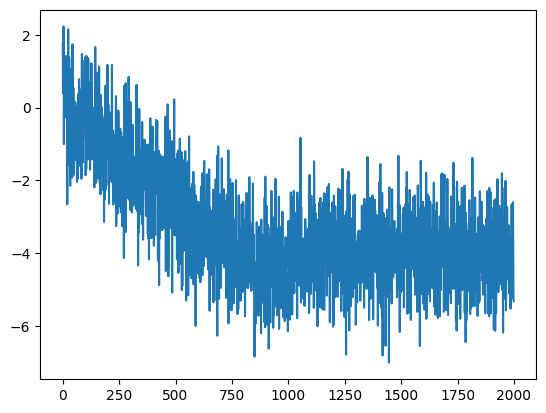

In [76]:
plt.plot(Y)

In [40]:
df = pd.DataFrame({"Time": Time, "Treated": Treated, "Treated_Time": Treated * (Time - Event_Time)})
results = sm.OLS(Y, sm.add_constant(df)).fit()
results.params

const          -0.035946
Time           -0.005019
Treated         1.116012
Treated_Time    0.004923
dtype: float64

In [41]:
results.bse

const           0.061834
Time            0.000107
Treated         0.087512
Treated_Time    0.000152
dtype: float64

In [42]:
print("Time: actual coefficient:", coef_Time)
print("Treated: actual coefficient:", coef_Treated)
print("Time * Treated: actual coefficient", coef_Time_Treated)

Time: actual coefficient: -0.005
Treated: actual coefficient: 1
Time * Treated: actual coefficient 0.005


# Market Returns

In [46]:
np.random.seed(0)
coef_Time = -2 / num
coef_Treated = 3
coef_Time_Treated = 2 / num
Event_Time = num // 2
Market = coef_Time * Time + np.random.normal(0, 1, num)
Y = 1.5 * Market - 1 + coef_Treated * Treated + coef_Time_Treated * (Time - Event_Time) * Treated + np.random.normal(0, 1, num) # 1.5 is beta, -1 is alpha
df = sm.add_constant(pd.DataFrame({"Market": Market[:Event_Time]}))

In [47]:
Market_est = Market[:Event_Time]
Y_est = Y[:Event_Time]
df_est = sm.add_constant(pd.DataFrame({"X": Market_est}))

In [48]:
results = sm.OLS(Y_est, df_est).fit()
results.params

const   -1.066438
X        1.472081
dtype: float64

In [50]:
#alpha = results.params.const
#beta = results.params.X
X_full = sm.add_constant(Market)
Y_pred = results.predict(X_full)
AR = Y - Y_pred # abnormal return

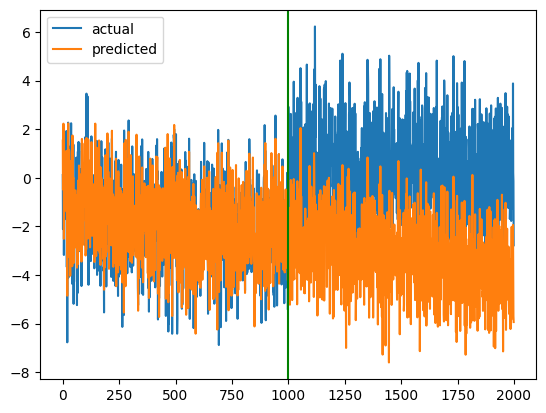

In [51]:
plt.plot(Y, label = "actual")
plt.plot(Y_pred, label = "predicted")
plt.axvline(Event_Time, color = 'green')
plt.legend()

In [33]:
pre_window = 10
post_window = 10
AR_pre_event = AR[Event_Time - pre_window : Event_Time]
AR_post_event = AR[Event_Time : Event_Time + post_window]

t_stat, p_value = scipy.stats.ttest_1samp(AR_pre_event, popmean=0)
t_stat, p_value

(-0.2065837087720005, 0.8409329432050487)

In [34]:
t_stat, p_value = scipy.stats.ttest_1samp(AR_post_event, popmean=0)
t_stat, p_value

(10.753505907177026, 1.9484572071728777e-06)

# Joint-Test Problem

In [77]:
np.random.seed(0)
num = 2000
event_time = num // 2
pre_window = 100
post_window = 100

# Pre-event: Market in [-1, 0]
Market_pre = np.random.uniform(-1, 0, event_time)

# Post-event: Market in [0, 1]
Market_post = np.random.uniform(0, 1, num - event_time)

Market = np.concatenate((Market_pre, Market_post))

# True model is quadratic, and there is no actual event effect
alpha_true = 0.5 # constant term
beta_true = 1.0 # linear term
gamma_true = 2.0  # quadratic term
noise = np.random.normal(0, 0.5, num)

# Note that the same model is used for all time; there is no event in terms of R vs. time
R = alpha_true + beta_true * Market + gamma_true * Market**2 + noise

# Estimate linear model on pre-event data
X_linear = sm.add_constant(Market[:event_time])
model = sm.OLS(R[:event_time], X_linear).fit()

# Predict over entire period
X_all = sm.add_constant(Market)
R_pred = model.predict(X_all)

# Compute abnormal returns
AR = R - R_pred

# Focus on event window (just after event_time)
AR_post = AR[event_time:event_time + post_window]
AR_pre = AR[event_time - pre_window:event_time]

# Perform t-test: is mean AR significantly different from 0 in the post-window?
t_stat, p_val = scipy.stats.ttest_1samp(AR_post, popmean=0)
t_stat, p_val

(14.723033988681616, 1.1168851234221893e-26)

In [78]:
# Perform t-test: is mean AR significantly different from 0 in the pre-window?
t_stat, p_val = scipy.stats.ttest_1samp(AR_pre, popmean=0)
t_stat, p_val

(-0.38201401737873514, 0.7032697544014301)

-0.01890619107403832

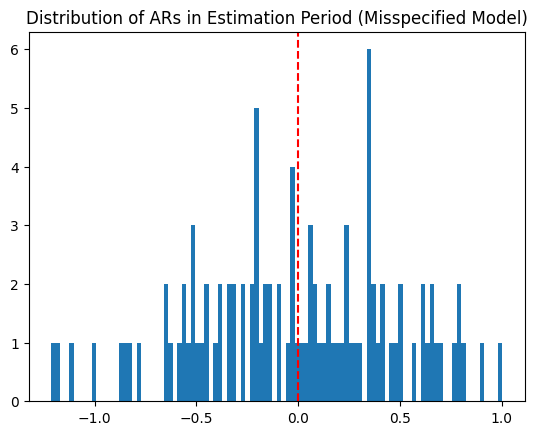

In [59]:
plt.hist(AR[event_time - pre_window:event_time], bins=100)
plt.title("Distribution of ARs in Estimation Period (Misspecified Model)")
plt.axvline(0, color='red', linestyle='--')
AR[event_time - pre_window:event_time].mean()

# Generating an autocorrelated noise function

#### Our goal: create an autocorrelated error function with mean 0, standard deviation 1, and a correlation of 0.9

In [64]:
np.random.seed(0)
X = np.random.normal(0, 1, 10000)
X.mean(), X.std()

(-0.018433720158265818, 0.9875565681761208)

In [65]:
((X[0:-1] * X[1:]).mean() - X[0:-1].mean() * X[1:].mean())/X[0:-1].std(ddof = 1)/X[1:].std(ddof = 1)

0.005034218396008701

In [66]:
scipy.stats.pearsonr(X[0:-1], X[1:])

PearsonRResult(statistic=0.005034721918552807, pvalue=0.6146920221395419)

In [67]:
def make_error(corr_const, sigma, num):
  err = list()
  prev = np.random.normal(0, sigma)
  for n in range(num):
    prev = corr_const * prev + (1 - corr_const) * np.random.normal(0, sigma)
    err.append(prev)
  return np.array(err)

In [68]:
err = make_error(0.9, 1, 10000)
np.corrcoef(err[0:-1], err[1:])[0,1] # Check that standard deviation is correct.  It is!

0.9012661192094201

In [69]:
err.mean(), err.std() # Check that mean and standard deviation are correct.  Nope!  Standard deviation is too small

(0.010643804644086593, 0.22921013352849195)

#### Make sure that the sum of the squares of the standard deviations of the two independent components is 1

In [70]:
def make_error2(corr_const, sigma, num):
  err = list()
  prev = np.random.normal(0, sigma)
  for n in range(num):
    prev = corr_const * prev + np.sqrt(1 - corr_const**2) * np.random.normal(0, sigma)
    err.append(prev)
  return np.array(err)

In [71]:
err2 = make_error2(0.9, 1, 10000)
np.corrcoef(err2[0:-1], err2[1:])[0,1]

0.9050879052809591

In [72]:
err2.mean(), err2.std() # Standard deviation is right!

(-0.02540363147229521, 1.0221665307452543)